# K-Means Clustering <br><sub>Author: Greg Holste<br></sub>

## Theory

K-Means clustering is an **unsupervised learning** technique for continuous-valued data. This approach is unsupervised because the data are *unlabeled*, meaning the response variable or target of interest is unknown; we have a data matrix $X \in \mathbb{R}^{min(n,p)}$ with $n$ samples and $p$ features, and are interested in finding $K$ groups (or "clusters") of the most similar observations.

In short, we want to assign the $n$ observations to $K$ clusters such that the samples in a cluster are more similar to each other than to the samples in other clusters. We first define a dissimilarity measure $d_j$ for the $j^{th}$ feature such that $D(x_i, x_{i'}) = \sum_{j=1}^p d_j(x_{ij}, x_{i'j})$ is the dissimilarity between samples $i$ and $i'$.

A common choice is the Euclidean distance $d_j(x_{ij}, x_{i'j}) = (x_{ij} - x_{i'j})^2 = ||x_i - x_{i'}||^2$. Then we want to find the **encoder** $C(i) = k$, which maps sample $i$ to cluster $k$, that minimizes $$W(C) = \sum_{k=1}^K \sum_{i:C(i)=k} ||x_i - \bar{x}_k||^2,$$ where $x_i$ is the vector $(x_{i1},\dots,x_{ip})$ and $\bar{x}_k$ is the $k^{th}$ mean; that is, it is the mean vector (centroid) of all observations belonging to class $k$. $W(C)$ is often called the "within-cluster scatter."



$\DeclareMathOperator*{\argmin}{\arg\!\min}$In principle we could exhaustively search all unique sample-to-cluster assignments, however as you can imagine this becomes practically impossible for even small $n$ and $K$. For example, the number of unique assignments of $n=19$ samples to $K=4$ clusters is approximately $10^{10}$. Instead... we proceed with a "greedy" iterative algorithm:
0. Randomly initialize $K$ means/centroids
1. Assign each sample to closest cluster mean: $$C(i) = \argmin_{1 \leq k \leq K} ||x_i - \bar{x}_k||^2$$
2. Find new K means with updated encoder
3. Repeat steps (1) and (2) until the encoder does not change

### Some considerations

Since this approach only explore a small subset of the parameter space, it will often converge to *local optima* (the price we pay for being "greedy"). So, it is common practice to **run the algorithm multiple times** with different random initialization of centroids. 

Another limitation of this algorithm is the need to *pre-specify* $K$. This is dependent on the problem we are trying to solve, but often we do not know or have a desired $K$ in mind. In this case, it is common to run K-means with various values of $K$ and compare the within-cluster scatter or sum of squared distances to nearest cluster mean.

This is sometimes called an **"elbow plot"** since we are looking for the smallest $K$ that provides a small-enough within-cluster scatter; that value of $K$ often presents itself as the "elbow" joint of this plot (as I'll demonstrate below). To be clear, this is a heuristic for choosing $K$; there are more nuanced, mathematically reliable methods of choosing the optimal $K$ such as the [Silhouette method](https://en.wikipedia.org/wiki/Silhouette_(clustering)) and the [Gap statistic](https://statweb.stanford.edu/~gwalther/gap).

Anway, that's the gist of it! Let's see it in action on a simple dataset.

## Simple Application

In [4]:
from kmeans import KMeans  # custom K-Means implementation
import sklearn             # sci-kit-learn implementation

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

First, we'll create a toy dataset with $p=2$ continuous features forming $K=3$ clusters.

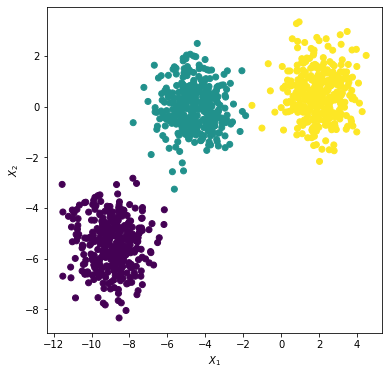

In [5]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=3, random_state=170)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")

plt.show()

Now, we can apply our implementation of K-Means – in `kmeans.py` – to this data, specifying $K=3$ and $20$ random initializations of centroids. This will return our encoder `C` (list of cluster memberships), the within-cluster scatter `SSE` (sum of squared distances to cluster centroids), and the $K=3$ centroids `M`.

In [6]:
C, SSE, M = KMeans(data=X, K=3, inits=20)

We can now compare this with sklearn's implementation of K-Means.

In [7]:
sk = sklearn.cluster.KMeans(n_clusters=3, init="random", n_init=20,
                            random_state=0, max_iter=100).fit(X)

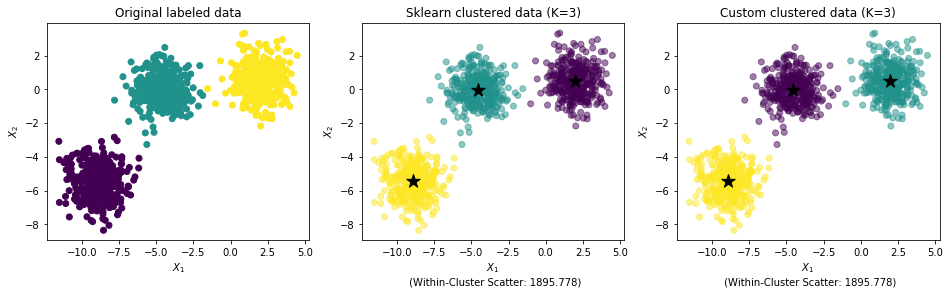

In [8]:
fig, ax =  plt.subplots(1, 3, figsize=(16,4))
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].set_title("Original labeled data")
ax[0].set_xlabel("$X_1$")
ax[0].set_ylabel("$X_2$")

ax[1].scatter(X[:, 0], X[:, 1], c=sk.labels_, alpha=0.5)
ax[1].scatter(sk.cluster_centers_[:, 0], sk.cluster_centers_[:, 1], marker="*", s=200, c="black")
ax[1].set_title("Sklearn clustered data (K=3)")
ax[1].set_xlabel(f"$X_1$ \n (Within-Cluster Scatter: {round(sk.inertia_, 3)})")
ax[1].set_ylabel("$X_2$")

ax[2].scatter(X[:, 0], X[:, 1], c=C, alpha=0.5)
ax[2].scatter(M[:, 0], M[:, 1], marker="*", s=200, c="black")
ax[2].set_title("Custom clustered data (K=3)")
ax[2].set_xlabel(f"$X_1$ \n (Within-Cluster Scatter: {round(SSE, 3)})")
ax[2].set_ylabel("$X_2$")

plt.show()

Woo – our implementation and `sklearn`'s implementation gave the same results!! You can see both methods "misclassified" a single point near $(-1, -1)$. Noise in the data and overlapping/nearby classes will inevitably cause misclassifications. Besides, we usually won't have a "ground truth" to compare to anyway.

### Choosing K

Obviously $K$ should be $3$, but let's "confirm" that with an elbow plot. Here we'll run K-Means for $K=1,\dots,6$ and plot the sum of squared distances to the nearest cluster mean against $K$.

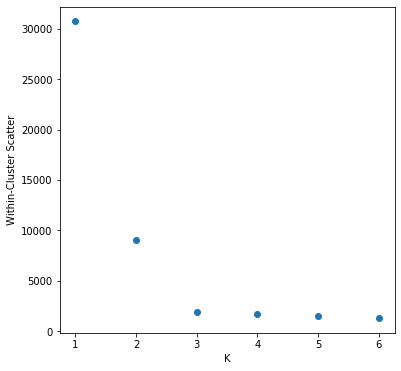

In [11]:
SSEs = []
for k in range(1, 7):
    _, SSE, _ = KMeans(data=X, K=k, inits=5)
    SSEs.append(SSE)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(list(range(1, 7)), SSEs)
ax.set_xlabel("K")
ax.set_ylabel("Within-Cluster Scatter")
plt.show()

Of course, we would choose $K=3$ here because increasing the number of clusters does not notably decrease the within-cluster scatter.